In [112]:
import os, io
from pathlib import Path
import math
from collections import defaultdict
from itertools import chain
import sqlite3
import logging
import logging.handlers
import multiprocessing as mp

from tqdm.notebook import tqdm
from PIL import Image, ImageDraw

import numpy as np
import cupy as cp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

from utils import *
from hdc import *

In [113]:
log = logging.getLogger('kmslog')
log.setLevel(logging.DEBUG)

if not log.hasHandlers():
    log.addHandler(logging.handlers.SysLogHandler(address = '/dev/log', facility=logging.handlers.SysLogHandler.LOG_LOCAL0))

config_var = 'SQLITE3_1.256.256_GRID_RETINA_stride_hdvs_similar'
config = Config(config_var)
RNG = np.random.default_rng()

if cp.cuda.is_available():
    xp = cp.get_array_module(cp.empty(1))
    xp_array_from_gpu = lambda a: a.get() if isinstance(a, cp.ndarray) else a
    xp_array_to_gpu = lambda a: cp.asarray(a) if isinstance(a, np.ndarray) else a
else:
    xp = cp.get_array_module(np.empty(1))
    xp_array_from_gpu = lambda a: a
    xp_array_to_gpu = lambda a: a

print(f'xp = {xp.__name__}')

hdc = Hdc(config.hdc_n, np)

xp = cupy


In [114]:
def ensure_dataset_folder():
    if not os.path.exists(config.dataset_path):
        print(f'Creating "{config.dataset_path}"')
        os.mkdir(config.dataset_path)

def is_table_exists(db_con, table_name):
    df = pd.read_sql('SELECT name FROM sqlite_master WHERE type=:type AND name=:table_name', params={'type': 'table', 'table_name': table_name}, con=db_con)
    return len(df) > 0

def is_table_empty(db_con, table_name):
    cur = train_db_con.cursor() 
    return len(cur.execute(f'SELECT * FROM {table_name} LIMIT 1').fetchall()) < 1

ensure_dataset_folder()
hdv_db_con = sqlite3.connect(os.path.join(config.dataset_path, config.hdv_db_file_name), autocommit=False)
train_db_con = sqlite3.connect(os.path.join(config.dataset_path, config.train_db_file_name), autocommit=False)
test_db_con = sqlite3.connect(os.path.join(config.dataset_path, config.test_db_file_name), autocommit=False)

In [115]:
dataset_source = os.path.join(config.dataset_source)

In [116]:
import struct
from array import array

#
# MNIST Data Loader Class
#
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        
        images = []
        
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images.append(img)
        
        return np.array(images), np.array(labels)
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)     

CPU times: user 251 ms, sys: 61.1 ms, total: 312 ms
Wall time: 311 ms


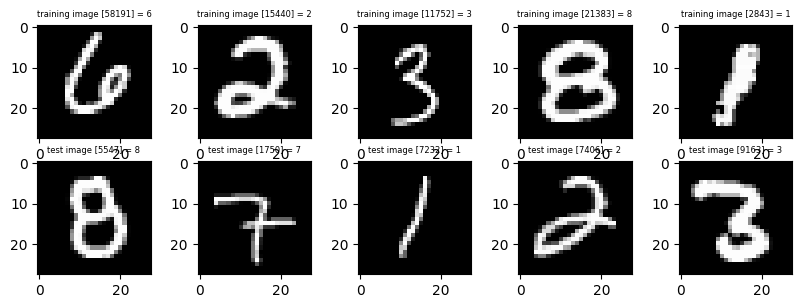

In [117]:
%%time
import random

#
# Set file paths based on added MNIST Datasets
#
training_images_filepath = os.path.join(dataset_source, 'train-images-idx3-ubyte')
training_labels_filepath = os.path.join(dataset_source, 'train-labels-idx1-ubyte')
test_images_filepath = os.path.join(dataset_source, 't10k-images-idx3-ubyte')
test_labels_filepath = os.path.join(dataset_source, 't10k-labels-idx1-ubyte')

#
# Helper function to show a list of images with their relating titles
#
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(10,5))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 6);        
        index += 1

#
# Load MINST dataset
#
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

# Show some random training and test images 
images_2_show = []
titles_2_show = []
for i in range(0, 5):
    r = random.randint(1, 60000)
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))    

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])        
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))    

show_images(images_2_show, titles_2_show)

In [118]:
SENSOR_GROUPS_COUNT = config.sensor_groups_count
SENSOR_RECEPTIVE_FIELD_SIZES = [8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
SENSOR_GROUP_SIZE = 4
SENSOR_GROUP_SQUARE = SENSOR_GROUP_SIZE ** 2 # no. of sensors within each group
SENSORS_COUNT = SENSOR_GROUPS_COUNT * SENSOR_GROUP_SQUARE # Dimension of encoding vector


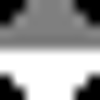
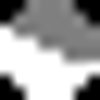
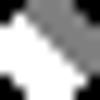
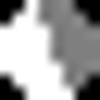
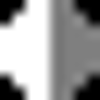
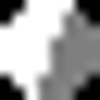
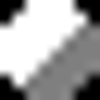
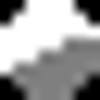
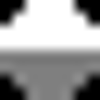
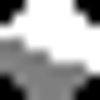
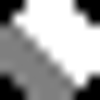
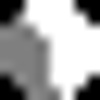
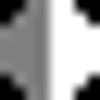
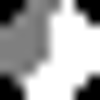
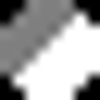
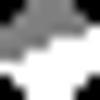

In [119]:
SENSOR_GROUPS_IMG = defaultdict(list) # key - sensor receptive field size, value - list of sensor images
captions = defaultdict(list)
sz = config.sample_size

for receptive_field_size in SENSOR_RECEPTIVE_FIELD_SIZES:
    for sensor_no in range(SENSOR_GROUP_SQUARE):
        canvas = Image.new('L', (sz, sz))
        draw = ImageDraw.Draw(canvas)
        draw.ellipse([0, 0, receptive_field_size - 1, receptive_field_size - 1], outline=0, fill=127, width=0)
        angle = sensor_no * 360 / SENSOR_GROUP_SQUARE
        draw.chord([0, 0, receptive_field_size - 1, receptive_field_size - 1], angle, angle + 180, outline=255, fill=255)
        captions[receptive_field_size].append(f'#{sensor_no} ({sensor_no // SENSOR_GROUP_SIZE}, {sensor_no % SENSOR_GROUP_SIZE})')
        SENSOR_GROUPS_IMG[receptive_field_size].append(canvas)

first_size = SENSOR_RECEPTIVE_FIELD_SIZES[0]
first_image_list = SENSOR_GROUPS_IMG[first_size]
first_caption_list = captions[first_size]
display_images_grid(list(map(lambda x: x.crop([0,0,first_size,first_size]).resize((100, 100)), first_image_list)), 
                    captions=first_caption_list,
                    col_count=SENSOR_GROUP_SIZE)

In [120]:
# Turn grayscale images to numpy arrays with weights which balance positive and negative areas
SENSOR_GROUPS = np.zeros((len(SENSOR_RECEPTIVE_FIELD_SIZES), SENSOR_GROUP_SQUARE, config.sample_size, config.sample_size), dtype=float)

for i, receptive_field_size in enumerate(SENSOR_RECEPTIVE_FIELD_SIZES):
    assert receptive_field_size in SENSOR_GROUPS_IMG.keys()
    imgs = SENSOR_GROUPS_IMG[receptive_field_size]
    sensor_group_for_this_receptive_field_size = np.array(list(map(np.array, imgs))).astype(float)
    SENSOR_GROUPS[i] = sensor_group_for_this_receptive_field_size
    
shape_save = SENSOR_GROUPS.shape
SENSOR_GROUPS = SENSOR_GROUPS.reshape(-1, config.sample_size ** 2)
# Due to rough granularity count of positive pixels and negative may be not eqaul => equalize via weight
SENSOR_GROUPS[SENSOR_GROUPS==255] = 1
counts_of_positives = (SENSOR_GROUPS == 1).sum(axis=1)
counts_of_negatives = (SENSOR_GROUPS == 127).sum(axis=1)
white_image = np.ones(SENSOR_GROUPS.shape[1])

for i, (p, n) in enumerate(zip(counts_of_positives, counts_of_negatives)):
    assert p > 0, (i, p)
    assert n > 0, (i, n)
    SENSOR_GROUPS[i][SENSOR_GROUPS[i] == 127] = -1 * (p / n)
    v = SENSOR_GROUPS[i] @ white_image
    assert np.isclose(v, 0), v

SENSOR_GROUPS = SENSOR_GROUPS.reshape(shape_save)
SENSOR_GROUPS = xp_array_to_gpu(SENSOR_GROUPS)
SENSOR_GROUPS.shape, np.unique_counts(xp_array_from_gpu(SENSOR_GROUPS))

((10, 16, 128, 128),
 UniqueCountsResult(values=array([-1.36363636, -1.34615385, -1.30952381, -1.26086957, -1.25925926,
        -1.25581395, -1.24      , -1.23529412, -1.22413793, -1.2125    ,
        -1.20895522, -1.18811881, -1.18518519, -1.17857143, -1.17391304,
        -1.17142857, -1.16666667, -1.15555556, -1.15384615, -1.15      ,
        -1.14492754, -1.13253012, -1.12765957, -1.1147541 , -1.11320755,
        -1.11111111, -1.10526316, -1.1047619 , -1.08490566, -1.08450704,
        -1.08333333, -1.08235294, -1.08      , -1.07407407, -1.06382979,
        -1.05405405, -1.04761905, -1.0462963 , -1.03636364, -1.03448276,
        -1.03333333, -1.02739726, -1.02020202, -1.        ,  0.        ,
         1.        ]), counts=array([     44,     104,      84,     138,     162,     172,     100,
             68,     348,     160,     134,     202,     324,     112,
            184,     210,     456,     360,     208,     240,     276,
            332,     376,     244,     106,      72,  

In [121]:
SENSOR_GROUP_AREAS = (SENSOR_GROUPS.reshape(SENSOR_GROUPS.shape[0], SENSOR_GROUPS.shape[1], -1) == 1).sum(axis=2) # number of ON pixels for each receptor
SENSOR_GROUP_AREAS.shape, SENSOR_GROUP_AREAS, SENSOR_GROUP_AREAS.mean(), SENSOR_GROUP_AREAS.min(), SENSOR_GROUP_AREAS.max(), SENSOR_GROUP_AREAS.std()

((10, 16),
 array([[ 26,  27,  29,  28,  26,  28,  29,  27,  26,  29,  29,  30,  26,
          30,  29,  29],
        [ 35,  31,  34,  33,  35,  33,  34,  31,  35,  33,  34,  34,  35,
          34,  34,  33],
        [ 38,  39,  41,  40,  38,  40,  41,  39,  38,  41,  41,  42,  38,
          42,  41,  41],
        [ 54,  50,  52,  52,  54,  52,  52,  50,  54,  52,  52,  55,  54,
          55,  52,  52],
        [ 56,  57,  60,  58,  56,  58,  60,  57,  56,  59,  60,  62,  56,
          62,  60,  59],
        [ 71,  66,  69,  68,  71,  68,  69,  66,  71,  68,  69,  71,  71,
          71,  69,  68],
        [ 74,  75,  79,  77,  74,  77,  79,  75,  74,  77,  79,  81,  74,
          81,  79,  77],
        [ 96,  90,  94,  92,  96,  92,  94,  90,  96,  92,  94,  97,  96,
          97,  94,  92],
        [100, 101, 106, 104, 100, 104, 106, 101, 100, 105, 106, 108, 100,
         108, 106, 105],
        [119, 113, 116, 115, 119, 115, 116, 113, 119, 115, 116, 120, 119,
         120, 116, 115]]

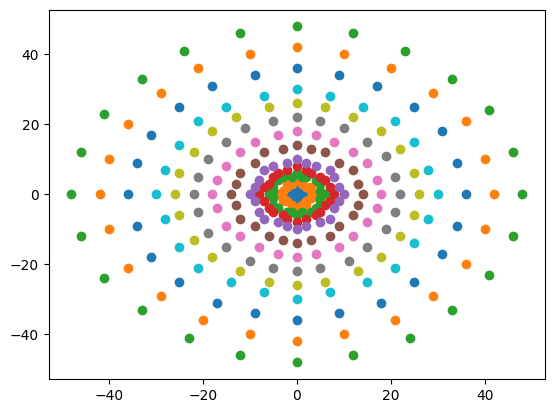

In [122]:
radiuses = [2, 4, 6, 8, 10, 14, 18, 22, 26, 30, 36, 42, 48]
rotations = 24
rotation_transfs = []

for i in range(rotations):
    theta = (2 * math.pi / rotations) * i
    cos_theta = math.cos(theta)
    sin_theta = math.sin(theta)
    transf = [
        [cos_theta, sin_theta, 0],
        [-sin_theta, cos_theta, 0],
        [0, 0, 1]
    ]
    rotation_transfs.append(np.array(transf))

rotation_transfs = np.array(rotation_transfs)

for radius in radiuses:
    arrow = np.array([radius, 0, 0])
    arrow_positions = (rotation_transfs @ arrow).astype(int)
    arrow_positions = set([(ap[0], ap[1]) for ap in arrow_positions])
    arrow_positions = list(arrow_positions)
    xs = list(map(lambda ap: ap[0], arrow_positions))
    ys = list(map(lambda ap: ap[1], arrow_positions))
    plt.scatter(xs, ys)

plt.show()

In [123]:
class SensorGroupDistributor(object):
    def __call__(self, sensor_group_index):
        return None

class SensorGroupDistributor_Grid(SensorGroupDistributor):
    def __init__(self):
        self.s = int(np.sqrt(SENSOR_GROUPS_COUNT))
        assert self.s ** 2 == SENSOR_GROUPS_COUNT
        assert self.s > 1
        self.field_size_index = 0
        self.field_size = SENSOR_RECEPTIVE_FIELD_SIZES[self.field_size_index]
        space_for_groups = self.s * self.field_size 
        self.dist_between_groups = np.round((config.sample_size - space_for_groups) / (self.s - 1), decimals=0)
        
    def __call__(self, sensor_group_index):
        x = (sensor_group_index % self.s) * (self.field_size + self.dist_between_groups)
        y = (sensor_group_index // self.s) * (self.field_size + self.dist_between_groups)
        return int(x), int(y), self.field_size, self.field_size_index

class SensorGroupDistributor_ConcentricCircles(SensorGroupDistributor):
    def __init__(self):
        self.half_sample_size = config.sample_size // 2
        radiuses = list(range(6, 112, 6))
        rotations = 24 #36
        rotation_transfs = []
        
        for i in range(rotations):
            theta = (2 * math.pi / rotations) * i
            cos_theta = math.cos(theta)
            sin_theta = math.sin(theta)
            transf = [
                [cos_theta, sin_theta, 0],
                [-sin_theta, cos_theta, 0],
                [0, 0, 1]
            ]
            rotation_transfs.append(np.array(transf))
        
        rotation_transfs = np.array(rotation_transfs)
        self.points = []
        self.field_size_indices = [] 
        
        for radius_index, radius in enumerate(radiuses):
            arrow = np.array([radius, 0, 0])
            arrow_positions = (rotation_transfs @ arrow).astype(int)
            arrow_positions += self.half_sample_size
            arrow_positions = set([(ap[0], ap[1]) for ap in arrow_positions])
            self.points.extend(list(arrow_positions))
            field_size = int(len(SENSOR_RECEPTIVE_FIELD_SIZES) * radius_index / len(radiuses))
            self.field_size_indices.extend([field_size] * len(arrow_positions))

        assert len(self.field_size_indices) == len(self.points)
        assert len(self.field_size_indices) >= SENSOR_GROUPS_COUNT, (len(self.field_size_indices), SENSOR_GROUPS_COUNT)
        
    def __call__(self, sensor_group_index):
        field_size_index = self.field_size_indices[sensor_group_index]
        field_size = SENSOR_RECEPTIVE_FIELD_SIZES[field_size_index]
        x, y = self.points[sensor_group_index]
        x_offset = x - field_size // 2
        y_offset = y - field_size // 2
        x_offset = max(0, min(x_offset, config.sample_size - field_size - 1))
        y_offset = max(0, min(y_offset, config.sample_size - field_size - 1))
        return x_offset, y_offset, field_size, field_size_index

class SensorGroupDistributor_2d_Gauss(SensorGroupDistributor):
    def __init__(self):
        self.half_sample_size = config.sample_size // 2
        self.max_radius = np.linalg.norm((self.half_sample_size, self.half_sample_size)) # max distance from center to corner
        self.mean = [0, 0]
        self.cov = [[self.half_sample_size, 0], [0, self.half_sample_size]]  # spherical covariance
        self.unique_xy_pairs = set()
        
    def __call__(self, sensor_group_index):
        for _ in range(10000):
            x, y = np.random.multivariate_normal(self.mean, self.cov, 1).T * 4
            x = int(x[0])
            y = int(y[0])
    
            if x < -self.half_sample_size or x >= self.half_sample_size or y < -self.half_sample_size or y >= self.half_sample_size:
                continue
    
            point_radius = np.linalg.norm((x, y))
            x = x + self.half_sample_size
            y = y + self.half_sample_size
            assert x >= 0 and x < config.sample_size
            assert y >= 0 and y < config.sample_size
            assert point_radius <= self.max_radius
    
            # field_size_index = 0
            field_size_index = int(len(SENSOR_RECEPTIVE_FIELD_SIZES) * point_radius / self.max_radius)
            assert field_size_index >= 0 and field_size_index < len(SENSOR_RECEPTIVE_FIELD_SIZES)
    
            field_size = SENSOR_RECEPTIVE_FIELD_SIZES[field_size_index]
            radius = field_size // 2
            
            if x > config.sample_size - radius or x < radius:
                continue
    
            if y > config.sample_size - radius or y < radius:
                continue
    
            if (x, y) in self.unique_xy_pairs:
                continue
    
            self.unique_xy_pairs.add((x, y))
            return x - radius, y - radius, field_size, field_size_index
        else:
            assert False, 'Failed to draw suitable x, y, radius within given attempts'

In [124]:
SENSOR_GROUP_DISTRIBUTOR = None

match config.retina_type:
    case 'grid': 
        SENSOR_GROUP_DISTRIBUTOR = SensorGroupDistributor_Grid()
    case '2d_gauss':
        SENSOR_GROUP_DISTRIBUTOR = SensorGroupDistributor_2d_Gauss()
    case 'concentric_circles':
        SENSOR_GROUP_DISTRIBUTOR = SensorGroupDistributor_ConcentricCircles()
    case _:
        assert False, config.retina_type

In [125]:
assert not SENSOR_GROUP_DISTRIBUTOR is None
RETINA_SENSOR_GROUP_INFOS = pd.DataFrame(columns=['group_index', 'field_size_index', 'x_offset', 'y_offset', 'receptive_field_size', 'x_center', 'y_center', 'radius'])
retina = xp.zeros((SENSOR_GROUPS_COUNT, SENSOR_GROUP_SQUARE, config.sample_size, config.sample_size))

for i in range(SENSOR_GROUPS_COUNT):
    x_offset, y_offset, field_size, field_size_index = SENSOR_GROUP_DISTRIBUTOR(i)
    assert x_offset >= 0 and x_offset <= config.sample_size - field_size, (i, x_offset, field_size)
    assert y_offset >= 0 and y_offset <= config.sample_size - field_size, (i, y_offset, field_size)
    
    for g in range(SENSOR_GROUP_SQUARE):
        receptor_plane = retina[i, g]
        assert y_offset <= receptor_plane.shape[0] - field_size, (y_offset, receptor_plane.shape[0], field_size) # make sure we don't roll too much
        assert x_offset <= receptor_plane.shape[1] - field_size, (x_offset, receptor_plane.shape[1], field_size) # with points wrapped around axes
        sensor_at_place = SENSOR_GROUPS[field_size_index, g]
        sensor_at_place = xp.roll(sensor_at_place, y_offset, axis=0)
        sensor_at_place = xp.roll(sensor_at_place, x_offset, axis=1)
        receptor_plane[:] = sensor_at_place
        
    RETINA_SENSOR_GROUP_INFOS.loc[len(RETINA_SENSOR_GROUP_INFOS)] = [
        i, # index_within_retina
        field_size_index,
        x_offset,
        y_offset,
        field_size,
        x_offset + field_size // 2,
        y_offset + field_size // 2,
        field_size // 2
    ]

RETINA_COMBINED = retina.reshape((-1, config.sample_size ** 2))
RETINA_POS = RETINA_COMBINED.copy()
RETINA_NEG = RETINA_COMBINED.copy()

RETINA_POS[RETINA_POS < 0] = 0
RETINA_NEG[RETINA_NEG > 0] = 0

RETINA_SENSOR_GROUP_AREAS = xp.zeros((SENSOR_GROUPS_COUNT, SENSOR_GROUP_SQUARE))

for _, sensor_group_info in RETINA_SENSOR_GROUP_INFOS.iterrows():
    sensor_group_index = sensor_group_info['group_index']
    field_size_index = sensor_group_info['field_size_index']
    RETINA_SENSOR_GROUP_AREAS[sensor_group_index] = SENSOR_GROUP_AREAS[field_size_index]

RETINA_SENSOR_GROUP_INFOS

,group_index,field_size_index,x_offset,y_offset,receptive_field_size,x_center,y_center,radius
0,0,0,0,0,8,4,4,4
1,1,0,8,0,8,12,4,4
2,2,0,16,0,8,20,4,4
3,3,0,24,0,8,28,4,4
4,4,0,32,0,8,36,4,4
...,...,...,...,...,...,...,...,...
251,251,0,88,120,8,92,124,4
252,252,0,96,120,8,100,124,4
253,253,0,104,120,8,108,124,4
254,254,0,112,120,8,116,124,4


In [126]:
mean = [0, 0]
cov = [[1, 0], [0, 3]] 
cortical_column_receptive_field_centers = RNG.multivariate_normal(mean, cov, config.cortical_columns_count)
cortical_column_receptive_field_centers *= config.cortical_column_receptive_field_size / 2
np.round(cortical_column_receptive_field_centers, decimals=1)

array([[  6.3, -99.7]])

In [127]:
# Column receptive field is a group of sensors within some radius
CORTICAL_COLUMN_RECEPTIVE_FIELDS = np.zeros((config.cortical_columns_count, SENSORS_COUNT), dtype='b') # aka masks for encoding vectors
CORTICAL_COLUMN_RECEPTIVE_FIELDS_INFO = pd.DataFrame(columns=['column_id', 'x_center', 'y_center', 'radius', 'sensor_group_indices'])
half_sample_size = config.sample_size // 2
cortical_column_receptive_field_radius = config.cortical_column_receptive_field_size // 2

for column_id, (x, y) in enumerate(cortical_column_receptive_field_centers):
    x = int(max(0, min(x + half_sample_size, config.sample_size - 1)))
    y = int(max(0, min(y + half_sample_size, config.sample_size - 1)))
    sensor_group_indices = []

    for _, sensor_group_info in RETINA_SENSOR_GROUP_INFOS.iterrows():
        group_receptive_field_size = sensor_group_info['receptive_field_size']
        group_x_center = sensor_group_info['x_offset'] + group_receptive_field_size // 2
        group_y_center = sensor_group_info['y_offset'] + group_receptive_field_size // 2
        group_x_center_column_pov = group_x_center - x
        group_y_center_column_pov = group_y_center - y
        dist = np.linalg.norm((group_x_center_column_pov, group_y_center_column_pov))

        if dist <= cortical_column_receptive_field_radius:
            group_index = sensor_group_info['group_index']
            sensor_group_index_lo = group_index * SENSOR_GROUP_SQUARE
            sensor_group_index_hi = sensor_group_index_lo + SENSOR_GROUP_SQUARE
            CORTICAL_COLUMN_RECEPTIVE_FIELDS[column_id][sensor_group_index_lo:sensor_group_index_hi] = 1
            sensor_group_indices.append(group_index)

    CORTICAL_COLUMN_RECEPTIVE_FIELDS_INFO.loc[len(CORTICAL_COLUMN_RECEPTIVE_FIELDS_INFO)] = [column_id, x, y, cortical_column_receptive_field_radius, sensor_group_indices]

CORTICAL_COLUMN_RECEPTIVE_FIELDS_INFO

,column_id,x_center,y_center,radius,sensor_group_indices
0,0,70,0,128,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."


CPU times: user 288 ms, sys: 63.1 ms, total: 351 ms
Wall time: 350 ms


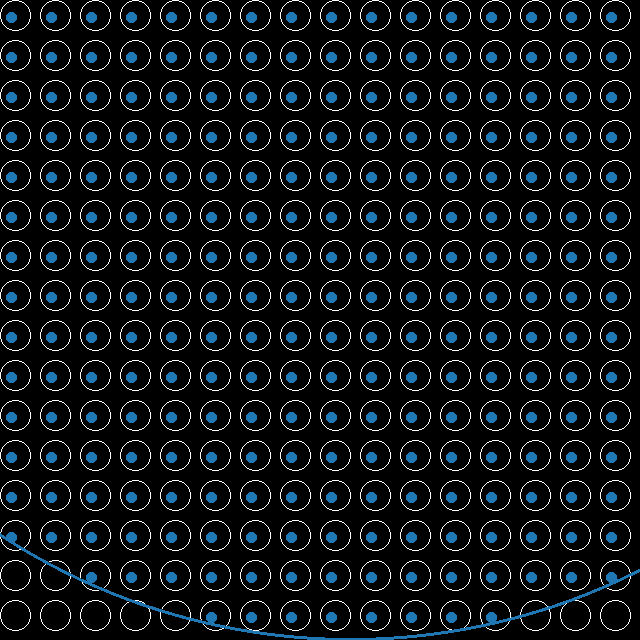

In [128]:
%%time
df_centers = pd.DataFrame(columns=['x', 'y'])
sz = int(np.sqrt(RETINA_COMBINED.shape[1]))
assert sz * sz == RETINA_COMBINED.shape[1]
k = 5
retina_map = Image.new('RGBA', (sz * k, sz * k), color='black')
retina_map_draw = ImageDraw.Draw(retina_map)
sensor_group_locs = np.array(RETINA_SENSOR_GROUP_INFOS[['x_center', 'y_center']])
retina_combined_host = xp_array_from_gpu(RETINA_COMBINED)
cortical_coloumn_chip_color_map = mpl.colormaps['tab20']
cortical_coloumn_chip_offsets = np.random.multivariate_normal([0, 0], [[4, 0], [0, 4]], config.cortical_columns_count).astype(int)

# step = 1 # Checking each sensor (receptor)
step = SENSOR_GROUP_SQUARE # Checking each sensor group

for i in range(0, retina_combined_host.shape[0], step):
    receptor_plane = retina_combined_host[i]
    receptor_plane = receptor_plane.reshape((sz, sz))
    receptor_plane *= receptor_plane # get rid of -1 
    vert = np.argwhere(receptor_plane.sum(axis=1) != 0).ravel() # project non-zero pixels on Y axis and get indices where they land
    horz = np.argwhere(receptor_plane.sum(axis=0) != 0).ravel() # project non-zero pixels on X axis and get indices where they land
    vert_lo = vert[0]
    vert_hi = vert[-1]
    horz_lo = horz[0]
    horz_hi = horz[-1]
    center_x = int((horz_lo + horz_hi) / 2)
    center_y = int((vert_lo + vert_hi) / 2)
    radius = int(max((vert_hi - vert_lo), (horz_hi - horz_lo)) / 2)
    cortical_column_chips_to_draw = []

    # Reverse check that discovered bulge on retina corresponds to a sensor group
    center_x_sensor_group_povs = center_x - sensor_group_locs[:,0]
    center_y_sensor_group_povs = center_y - sensor_group_locs[:,1]
    dist_from_sensor_group_centers = np.linalg.norm(np.vstack([center_x_sensor_group_povs, center_y_sensor_group_povs]).T, axis=1)
    assert dist_from_sensor_group_centers.shape == (SENSOR_GROUPS_COUNT,)
    closest_group_index = np.argmin(dist_from_sensor_group_centers)

    group_info = RETINA_SENSOR_GROUP_INFOS[RETINA_SENSOR_GROUP_INFOS['group_index'] == closest_group_index].iloc[0]
    assert np.linalg.norm((center_x - group_info['x_center'], center_y - group_info['y_center'])) <= group_info['radius']

    # Check that corresponding sensor group is within CORTICAL_COLUMN_RECEPTIVE_FIELDS
    necessary_stride_within_cort_column_receptive_fields = np.zeros(SENSORS_COUNT, dtype='b')
    necessary_stride_within_cort_column_receptive_fields[closest_group_index * SENSOR_GROUP_SQUARE:(closest_group_index+1) * SENSOR_GROUP_SQUARE] = 1
    necessary_stride_within_cort_column_receptive_fields_ones = (necessary_stride_within_cort_column_receptive_fields == 1).sum()
    
    for _, cortical_column_receptive_field_info in CORTICAL_COLUMN_RECEPTIVE_FIELDS_INFO.iterrows():
        column_id = cortical_column_receptive_field_info['column_id']
        cortical_column_group_indices = cortical_column_receptive_field_info['sensor_group_indices']
        cortical_column_receptive_field = CORTICAL_COLUMN_RECEPTIVE_FIELDS[column_id]
        scalar_prod = necessary_stride_within_cort_column_receptive_fields @ cortical_column_receptive_field
        
        if np.any(cortical_column_group_indices == closest_group_index):
            # discovered bulde (sensor group) is accounted for this column. Check that receptive field of this column (mask)
            # is aligned with this statement
            assert scalar_prod == necessary_stride_within_cort_column_receptive_fields_ones
            chip_color = cortical_coloumn_chip_color_map(column_id % cortical_coloumn_chip_color_map.N, bytes=True)
            chip_offsets = cortical_coloumn_chip_offsets[column_id]
            cortical_column_chips_to_draw.append((chip_offsets[0], chip_offsets[1], chip_color))
        else:
            # discovered bulde (sensor group) is NOT accounted for this column. Check that receptive field of this column (mask)
            # is aligned with this statement
            assert scalar_prod == 0

    center_x = k * center_x
    center_y = k * center_y
    radius = k * radius
    assert radius <= 100, radius
    retina_map_draw.circle((center_x, center_y), radius, width=1, outline=200)

    for chip_to_draw in cortical_column_chips_to_draw:
        retina_map_draw.circle((center_x + chip_to_draw[0], center_y + chip_to_draw[1]), radius / 3, outline=chip_to_draw[2], fill=chip_to_draw[2])
    
    df_centers.loc[len(df_centers)] = [center_x, center_y]

for _, cortical_column_receptive_field_info in CORTICAL_COLUMN_RECEPTIVE_FIELDS_INFO.iterrows():
    column_id = cortical_column_receptive_field_info['column_id']
    column_x_center = cortical_column_receptive_field_info['x_center']
    column_y_center = cortical_column_receptive_field_info['y_center']
    column_radius = cortical_column_receptive_field_info['radius']
    column_color = cortical_coloumn_chip_color_map(column_id % cortical_coloumn_chip_color_map.N, bytes=True)
    retina_map_draw.circle((column_x_center * k, column_y_center * k), column_radius * k, outline=column_color, width=3)

retina_map


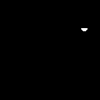
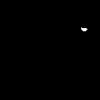
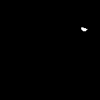
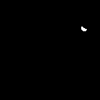
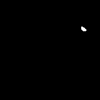
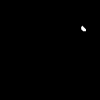
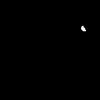
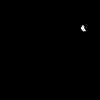
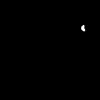
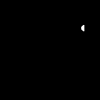
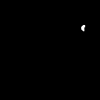
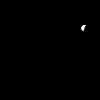
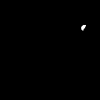
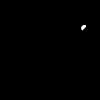
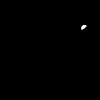
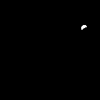
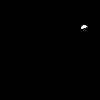
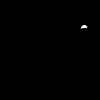
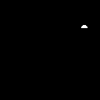
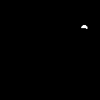
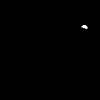
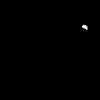
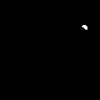
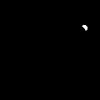
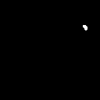
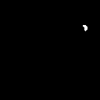
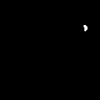
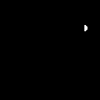
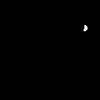
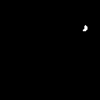
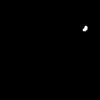
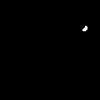
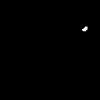
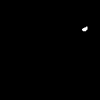
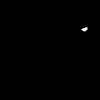
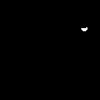

In [129]:
# For each sensor group we prepare bunch of specific samples (measured in steps here)
SPECIFIC_SAMPLES_IMG = defaultdict(list) # key - sensor group index, value - list of specific images
sz = config.sample_size
steps = 360 // 10 # 10 degrees

for _, sensor_group_info in RETINA_SENSOR_GROUP_INFOS.iterrows():
    sensor_group_index = sensor_group_info['group_index']
    x_offset = sensor_group_info['x_offset'] # where sensor group
    y_offset = sensor_group_info['y_offset'] # is located on retina
    receptive_field_size = sensor_group_info['receptive_field_size']
    
    for i in range(steps):
        canvas = Image.new('L', (sz, sz))
        draw = ImageDraw.Draw(canvas)
        angle = i * 360 / steps
        draw.chord([x_offset, y_offset, x_offset + receptive_field_size - 1, y_offset + receptive_field_size - 1], angle, angle + 180, outline=255, fill=255)
        SPECIFIC_SAMPLES_IMG[sensor_group_index].append(canvas)

sensor_group_index_to_show = RNG.choice(list(SPECIFIC_SAMPLES_IMG.keys()))
images_to_show = SPECIFIC_SAMPLES_IMG[sensor_group_index_to_show]
display_images_grid(list(map(lambda x: x.resize((100, 100)), images_to_show)), col_count=int(np.sqrt(steps)))

In [130]:
MINIMAL_ILLUMINATION_ABS_LEVEL = 255 * 0.1
MINIMAL_ILLUMINATION_DIFF_DB = 2 # dB
MINIMAL_ILLUMINATION_DIFF_RATIO = pow(10, MINIMAL_ILLUMINATION_DIFF_DB/20)

def sense_images(images):
    sense_ress = []
    image_masks = images.copy()
    image_masks[image_masks > 0] = 1

    sense_area = (RETINA_POS @ image_masks.T).T # for check of illuminated area (number of illuminated pixels)
    sense_level = (RETINA_POS @ images.T).T # for check of absolute illumination
    sense_neg_level = (RETINA_NEG @ images.T).T # for check of relative diff

    assert sense_area.shape == (len(images), SENSOR_GROUPS_COUNT * SENSOR_GROUP_SQUARE), sense_area.shape
    assert sense_area.shape == sense_level.shape
    assert sense_area.shape == sense_neg_level.shape
    
    # Base for calculations = AREA of illumination must be at least 1/2 of area of positive receptors
    # Next we exclude sensors which do not minimal LEVEL of illumination = area * (255 * 10%)
    # Finally we exclude sensors which do not have enough contrast (DIFF) - use NEG part of retina and use logarithmic scale (dB)
    for sense_area_i, sense_level_i, sense_neg_level_i in zip(sense_area, sense_level, sense_neg_level):
        # Per image cycle
        # sense_area_i is a matrix: row=sensor group, column=number of illuminated pixels for each receptor in this group
        sense_area_i = sense_area_i.reshape(-1, SENSOR_GROUP_SQUARE)  
        cond1 = (sense_area_i / RETINA_SENSOR_GROUP_AREAS) >= 0.5 # At least half of a positive area of each of sensors is activated
        cond1 = cond1.reshape(-1,)

        # sense_level_i is a matrix: row=sensor group, column=sum of illimination on positive part of each receptor
        sense_level_i = sense_level_i.reshape(-1, SENSOR_GROUP_SQUARE)
        sense_level_i[sense_level_i <= 0] = 1e-6 # to ease cond3
        cond2 = (sense_level_i > MINIMAL_ILLUMINATION_ABS_LEVEL * RETINA_SENSOR_GROUP_AREAS) # Illumination level of an area must exceed given threshold
        cond2 = cond2.reshape(-1,)

        # sense_neg_level_i is a matrix: row=sensor group, column=sum of illimination on negative part of each receptor
        sense_neg_level_i = xp.abs(sense_neg_level_i)
        sense_neg_level_i[sense_neg_level_i <= 0] = 1e-6 # to ease cond3
        cond3 = (sense_level_i.reshape(-1,) / sense_neg_level_i) >= MINIMAL_ILLUMINATION_DIFF_RATIO # Illumination of positive area must be > illumination of negative one
    
        sense_res = (cond1 & cond2 & cond3).astype(int) # mask of active sensors for particular image
        sense_ress.append(sense_res)

    return xp.array(sense_ress)

In [131]:
SPECIFIC_SAMPLES_REACTIONS = dict()

for sensor_group_index, specific_samples_img in tqdm(SPECIFIC_SAMPLES_IMG.items()):
    specific_samples_img = xp.array(specific_samples_img)
    specific_samples_img = specific_samples_img.reshape(specific_samples_img.shape[0], -1)
    reactions = xp_array_from_gpu(sense_images(specific_samples_img))
    SPECIFIC_SAMPLES_REACTIONS[sensor_group_index] = np.array(reactions)

SPECIFIC_SAMPLES_REACTIONS[0].shape

  0%|          | 0/256 [00:00<?, ?it/s]

(36, 4096)


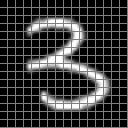
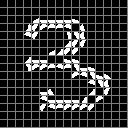

In [132]:
images = []
captions = []

image_index = RNG.choice(len(x_train))
# image_index = 9987
random_img_data = x_train[image_index]
random_img = Image.frombytes('L', size=(28, 28), data=random_img_data)
random_img = random_img.resize((config.sample_size, config.sample_size))
images.append(random_img)
captions.append(f'#{image_index}')

random_img_arr = xp.array([random_img])
random_img_arr = random_img_arr.reshape(1, -1)
random_img_receptors = xp_array_from_gpu(sense_images(random_img_arr))
random_img_receptors_dims = random_img_receptors.shape[1]
random_img_receptors = random_img_receptors.reshape(SENSOR_GROUPS_COUNT, -1)
assert (random_img_receptors == 1).sum() > 0
sz = config.sample_size
sensor_map_image = np.zeros((sz, sz))

best_is = set()
layers = []

for sensor_group_index, sensor_group in enumerate(random_img_receptors):
    assert sensor_group.shape == (SENSOR_GROUP_SQUARE, )
    speficic_samples_reactions_for_sensor_group = SPECIFIC_SAMPLES_REACTIONS[sensor_group_index]
    
    if np.any(sensor_group > 0):
        # Find most similar reaction among specific samples of reactions for given sensor group
        a = np.zeros(random_img_receptors_dims)
        assert a.shape[0] == speficic_samples_reactions_for_sensor_group.shape[1]
        a[sensor_group_index * SENSOR_GROUP_SQUARE:sensor_group_index * SENSOR_GROUP_SQUARE + SENSOR_GROUP_SQUARE] = sensor_group
        a = a / np.linalg.norm(a)
        b = speficic_samples_reactions_for_sensor_group
        b = (b.T / np.linalg.norm(b, axis=1)).T
        cos_sim = (a @ b.T)
        best_i = np.argmax(cos_sim)
        best_is.add((sensor_group_index, best_i))
        most_similar_specific_sample = np.array(SPECIFIC_SAMPLES_IMG[sensor_group_index][best_i])
        assert most_similar_specific_sample.shape == (sz, sz)
        layers.append(most_similar_specific_sample)

for layer in layers:
    sensor_map_image += layer
    
sensor_map_image[sensor_map_image != 0] = 255
images.append(Image.frombytes('L', (sz, sz), data=(sensor_map_image).ravel().astype('b')))
captions.append('')

lay_grid_local = lambda i: lay_grid(i, 8)
display_images(list(map(lay_grid_local, images)), captions=captions)


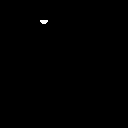
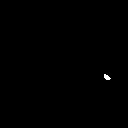
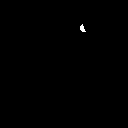
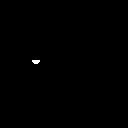
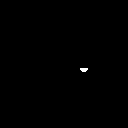
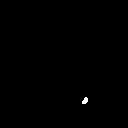
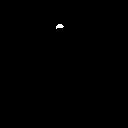
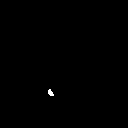
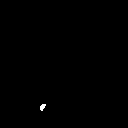
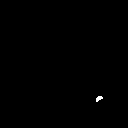
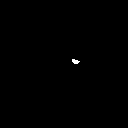
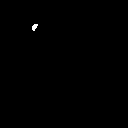
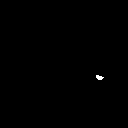
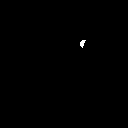
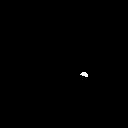
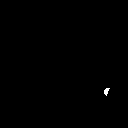
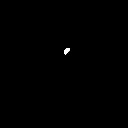
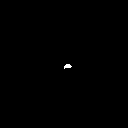
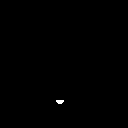
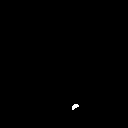
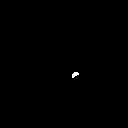
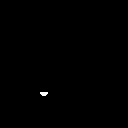
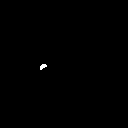
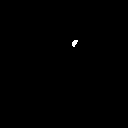
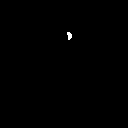
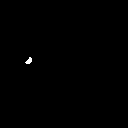
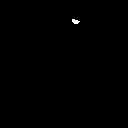
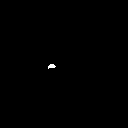
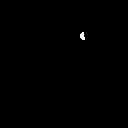
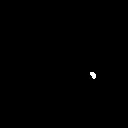
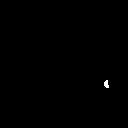
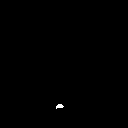
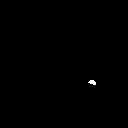
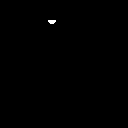
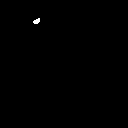
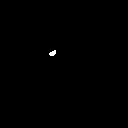
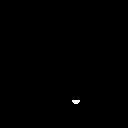
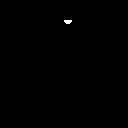
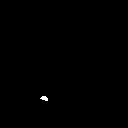
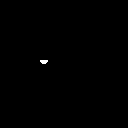
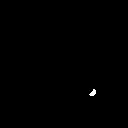
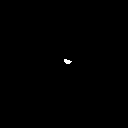
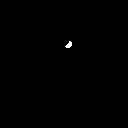
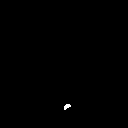
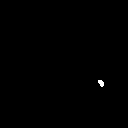
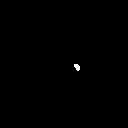
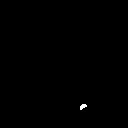
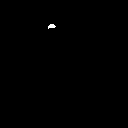
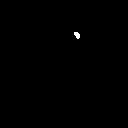
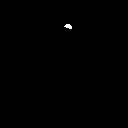
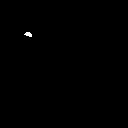
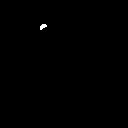
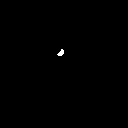
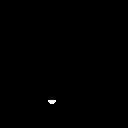
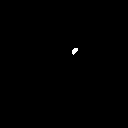
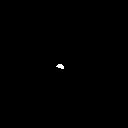
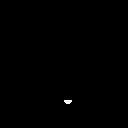
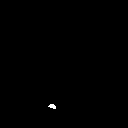
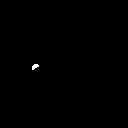
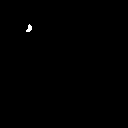
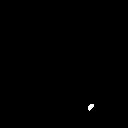
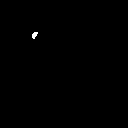
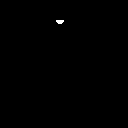
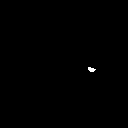
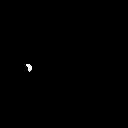

In [133]:
images = []

for sensor_group_index, i in best_is:
    images_to_show = SPECIFIC_SAMPLES_IMG[sensor_group_index][i]
    images.append(images_to_show)
    
display_images_grid(images, col_count=8)

In [134]:
def get_grid_offsets(lo, hi):
    assert hi > lo
    points = []
    rng = range(lo, hi + 1)
    
    for i in rng:
        for j in rng:
            if i == 0 and j == 0:
                continue
                
            points.append((i,j))
    
    return np.array(points)

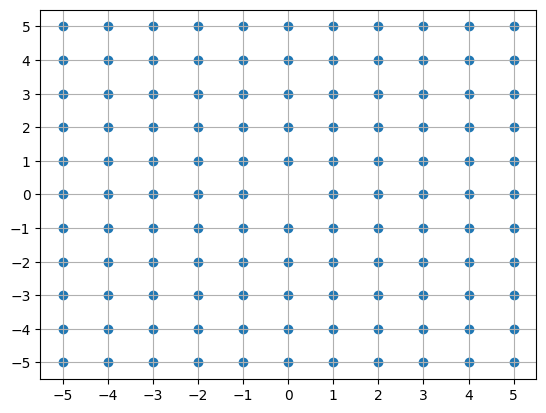

(120, 2)

In [135]:
points = get_grid_offsets(-5, 5)
plt.scatter(points[:,0], points[:,1])
plt.xticks(range(np.min(points[:,0]), np.max(points[:,0]) + 1, 1))
plt.yticks(range(np.min(points[:,1]), np.max(points[:,1]) + 1, 1))
plt.grid()
plt.show()
points.shape

In [136]:
def get_clock_offsets(radiuses):
    assert np.all(np.array(radiuses) > 0)
    hours = 12
    rotation_transfs = []
    
    for i in range(hours):
        theta = (2 * math.pi / hours) * i
        cos_theta = math.cos(theta)
        sin_theta = math.sin(theta)
        transf = [
            [cos_theta, sin_theta, 0],
            [-sin_theta, cos_theta, 0],
            [0, 0, 1]
        ]
        rotation_transfs.append(np.array(transf))
    
    rotation_transfs = np.array(rotation_transfs)
    points = dict()
    
    for radius in radiuses:
        arrow = np.array([radius, 0, 0])
        arrow_positions = (rotation_transfs @ arrow).astype(int)
        # duplicates handling
        arrow_positions_codes = [''.join(map(str, ap)) for ap in arrow_positions]
        points.update(zip(arrow_positions_codes, arrow_positions))
    
    if '000' in points: 
        del points['000']

    return np.array(list(points.values()))[:,0:2]

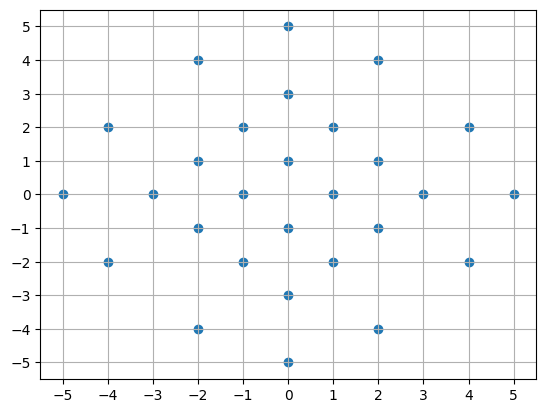

(28, 2)

In [137]:
radiuses = [5, 3, 1]
points = get_clock_offsets(radiuses)
plt.grid()
plt.scatter(points[:,0], points[:,1])
plt.xticks(range(np.max(radiuses) * -1, np.max(radiuses) + 1, 1))
plt.yticks(range(np.max(radiuses) * -1, np.max(radiuses) + 1, 1))
plt.show()
points.shape

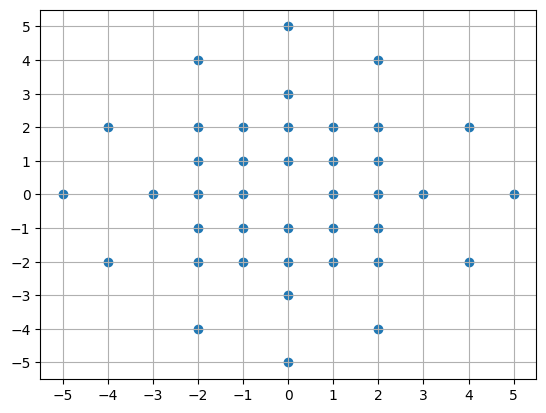

(40, 2)

In [138]:
points1 = get_grid_offsets(-2, 2)
points2 = get_clock_offsets([5, 3])
points = np.array(list(set(map(lambda x: (int(x[0]), int(x[1])), chain(points1, points2)))))
plt.grid()
plt.scatter(points[:,0], points[:,1])
plt.xticks(range(np.max(radiuses) * -1, np.max(radiuses) + 1, 1))
plt.yticks(range(np.max(radiuses) * -1, np.max(radiuses) + 1, 1))
plt.show()
points.shape

In [139]:
def generate_image_offsets(image, offsets):
    sz = int(np.sqrt(image.shape[0]))
    assert sz * sz == image.shape[0]
    images = []

    for off in offsets:
        image_offed = image.reshape(sz, sz)

        # offset by x
        x = off[0]
        image_offed = np.roll(image_offed, x, axis=1)
        cols_to_wipeout = [min(x, 0) + i for i in range(abs(x))]
        image_offed[:,cols_to_wipeout] = 0

        # offset by y
        y = off[1]
        image_offed = np.roll(image_offed, y, axis=0)
        rows_to_wipeout = [min(y, 0) + i for i in range(abs(y))]
        image_offed[rows_to_wipeout,:] = 0
        
        image_offed = image_offed.reshape(-1)
        images.append(image_offed)

    return np.array(images)


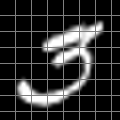
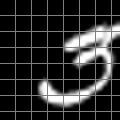
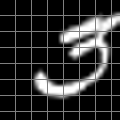
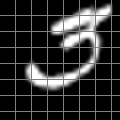
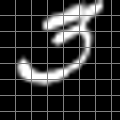
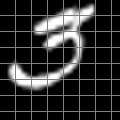
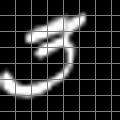
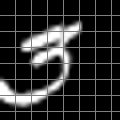
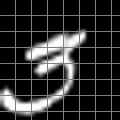
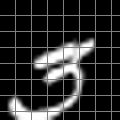
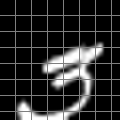
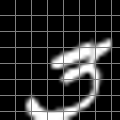
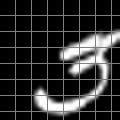
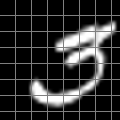
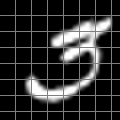
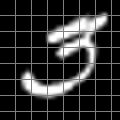
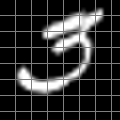
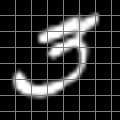
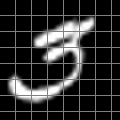
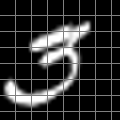
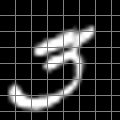
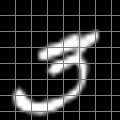
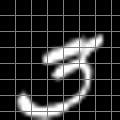
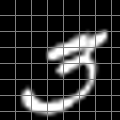
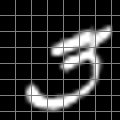
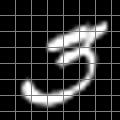
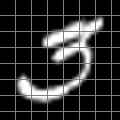
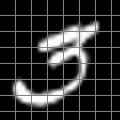
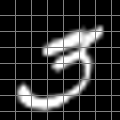

In [140]:
xy_offsets = np.concat([[[0, 0]], get_clock_offsets([5, 3, 1])])
img_data = x_train[RNG.choice(len(x_train))]

with Image.frombytes('L', size=(28, 28), data=img_data) as img:
    image_offsets = generate_image_offsets(np.array(img).ravel(), xy_offsets)

captions = list(map(lambda x: f'x={x[0]}, y={x[1]}', xy_offsets))
display_images_grid(list(map(lambda i: lay_grid(matrix_to_image(i).resize((120, 120)), 16), image_offsets)), captions=captions, col_count=8)

In [141]:
def create_datasets(x_dataset, y_dataset, samples_count, id_offset):
    image_indices = RNG.choice(len(x_dataset), samples_count, replace=False)
    image_dataset = defaultdict(list)
    image_encoding_dataset = defaultdict(list)

    xy_offsets_grid = get_grid_offsets(-2, 2)
    xy_offsets_clock = get_clock_offsets([5, 3])
    xy_offsets = np.array(list(set(map(lambda x: (int(x[0]), int(x[1])), chain(xy_offsets_grid, xy_offsets_clock)))))
    xy_offsets = np.concat([[[0, 0]], xy_offsets])
    
    for i in tqdm(image_indices):
        img_data = x_dataset[i]
        img_label = y_dataset[i]
    
        with Image.frombytes('L', size=(28, 28), data=img_data) as img:
            b = io.BytesIO()
            img = img.resize((config.sample_size, config.sample_size))
            img.save(b, format='PNG')
            png = b.getvalue()
    
            image_id = i + id_offset
            image_dataset['image_id'].append(image_id)
            image_dataset['value'].append(str(img_label))
            image_dataset['png'].append(png)
    
            image_offsets = generate_image_offsets(np.array(img).ravel(), xy_offsets)
            image_offset_encodings = sense_images(xp.array(image_offsets))
            
            for ioe, (x, y) in zip(image_offset_encodings, xy_offsets):
                for column_id in range(-1, config.cortical_columns_count): # -1 is used to store original encoding
                    image_encoding_dataset['image_id'].append(image_id)
                    image_encoding_dataset['column_id'].append(column_id)
                    image_encoding_dataset['retina_type'].append(config.retina_type)
                    image_encoding_dataset['offset_x'].append(x)
                    image_encoding_dataset['offset_y'].append(y)

                    if column_id == -1:
                        ioe = xp_array_from_gpu(ioe).astype('b')
                        image_encoding_dataset['encoding'].append(ioe)
                    else:
                        column_rec_field = CORTICAL_COLUMN_RECEPTIVE_FIELDS[column_id]
                        assert column_rec_field.shape == ioe.shape
                        column_ioe = ioe * column_rec_field # masking
                        column_ioe = xp_array_from_gpu(column_ioe).astype('b')
                        image_encoding_dataset['encoding'].append(column_ioe)
    
    image_dataset = pd.DataFrame(image_dataset)
    image_encoding_dataset = pd.DataFrame(image_encoding_dataset)
    return image_dataset, image_encoding_dataset

def save_datasets(image_dataset, image_encoding_dataset, db_con):
    image_dataset.to_sql(name='images', con=db_con)
    image_encoding_dataset.to_sql(name='image_encodings', con=db_con)

    cur = db_con.cursor()
    cur.execute('CREATE INDEX ix_images_image_id ON images(image_id)')
    cur.execute('CREATE INDEX ix_image_encodings_image_id ON image_encodings(image_id)')
    cur.execute('CREATE INDEX ix_image_encodings_column_id ON image_encodings(column_id)')
    cur.execute('CREATE INDEX ix_image_encodings_retina_type_id ON image_encodings(retina_type)')
    cur.execute('CREATE INDEX ix_image_encodings_image_id_column_id ON image_encodings(image_id, column_id)')
    cur.execute('ALTER TABLE image_encodings ADD COLUMN hdv BLOB')
    db_con.commit()

In [142]:
train_tuple = (train_db_con, x_train, y_train, config.dataset_train_samples_count, 0)
test_tuple = (test_db_con, x_test, y_test, config.dataset_test_samples_count, 100_000_000)

for db_con, x, y, samples_count, id_offset in [train_tuple, test_tuple]:
    if not is_table_exists(db_con, 'images'):
        image_dataset, image_encoding_dataset = create_datasets(x, y, samples_count, id_offset)
        save_datasets(image_dataset, image_encoding_dataset, db_con)

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [143]:
STRIDE_HDVS = dict() # to be used in RO mode ONLY in multiprocessing without locks

if not is_table_exists(hdv_db_con, 'stride_hdvs'):
    # Generate all possible stride hdvs in advance.
    # This would allow to use stride_hdvs in RO-mode in multiprocessing without any locks and data corruption
    # Generate stride HDV from a common pool of sensor HDV. This is to make stride hdvs which share the same sensors to be close in cos sim space
    if SENSOR_GROUP_SQUARE > 16:
        assert False, f'Not implemented yet for SENSOR_GROUP_SQUARE={SENSOR_GROUP_SQUARE}'

    sensor_hdvs = hdc(SENSOR_GROUP_SQUARE)

    for i in range(1, pow(2, SENSOR_GROUP_SQUARE)):
        stride_code = np.binary_repr(i, width=SENSOR_GROUP_SQUARE) # e.g. 1100100010001110
        assert stride_code != '0' * SENSOR_GROUP_SQUARE
        sensor_hdv_indices = list(map(int, list(stride_code))) # e.g [1,1,0,0,1,0,0,0,1,0,0,0,1,1,1,0]
        stride_hdv = np.compress(sensor_hdv_indices, sensor_hdvs, axis=0)
        STRIDE_HDVS[stride_code] = hdc.bundle(stride_hdv)
        # STRIDE_HDVS[stride_code] = hdc()

    cur = hdv_db_con.cursor()
    cur.execute('CREATE TABLE stride_hdvs(code TEXT, hdv TEXT)')
    cur.execute('CREATE UNIQUE INDEX ix_stride_hdvs_code ON stride_hdvs(code)')
    cur.executemany('INSERT INTO stride_hdvs (code, hdv) VALUES (:code, :hdv)', [{'code': code, 'hdv': hdv} for code, hdv in STRIDE_HDVS.items()])
    hdv_db_con.commit()
else:
    df_stride_hdvs = pd.read_sql('SELECT code, hdv FROM stride_hdvs', con=hdv_db_con)
    hdvs = map(lambda x: np.frombuffer(x, dtype='b'), df_stride_hdvs['hdv'])
    STRIDE_HDVS.update(zip(df_stride_hdvs['code'], hdvs))

In [144]:
random_stride_code = RNG.choice(list(STRIDE_HDVS.keys()))
random_stride_hdv = STRIDE_HDVS[random_stride_code]
# there must be bunch of similar stride hdvs in DB
sims = np.array(list(map(lambda item: hdc.sim(random_stride_hdv, item[1]) if item[0] != random_stride_code else 0, STRIDE_HDVS.items())))
assert (sims > 0.055).sum() > 0

In [145]:
def is_any_hdvs_missing(db_con):
    cur = db_con.cursor() 
    rows = cur.execute('SELECT 1 FROM image_encodings WHERE (hdv IS NULL OR LENGTH(hdv)<>:hdv_N) LIMIT 1', {'hdv_N': config.hdc_n}).fetchall()
    return len(rows) > 0

def make_image_encoding_hdv(task):
    enc_index, encoding = task
    encoding_stride_hdvs = []

    empty_stride = '0' * SENSOR_GROUP_SQUARE
    # Fast conversion to string of 0s & 1s
    encoding_digits = ['0', '1']
    encoding_str = ''.join(np.take(encoding_digits, encoding).tolist())

    for stride_index in range(0, len(encoding_str), SENSOR_GROUP_SQUARE):
        stride_code = encoding_str[stride_index:stride_index + SENSOR_GROUP_SQUARE]

        if stride_code == empty_stride:
            continue
        
        stride_hdv = STRIDE_HDVS[stride_code] # all stride_codes must be pregenerated beforehand!!!
        stride_hdv = hdc.shift(stride_hdv, stride_index)
        encoding_stride_hdvs.append(stride_hdv)

    if encoding_stride_hdvs:
        encoding_hdv = hdc.bundle(encoding_stride_hdvs)
        assert encoding_hdv.shape[0] == hdc.N, encoding_hdv.shape
    else:
        encoding_hdv = hdc() # use fresh whitenoise hdv to denote blank image. Its cos sim will be near 0 when doing meaningful comparison with anything in the future

    return (enc_index, encoding_hdv)

def make_image_encoding_hdvs(db_con):
    workers = max(2, mp.cpu_count())
    
    with mp.Pool(processes=workers) as pool:
        cur = db_con.cursor()
        df_images = pd.read_sql('''SELECT DISTINCT(i.image_id) 
        FROM images i LEFT JOIN image_encodings e ON i.image_id=e.image_id
        WHERE (e.hdv IS NULL OR LENGTH(e.hdv)<>:hdv_N)''', params={'hdv_N': config.hdc_n}, con=db_con)
        
        for _, row in tqdm(df_images.iterrows(), total=len(df_images)):
            image_id = int(row['image_id'])
            df_image_encodings = pd.read_sql('SELECT "index", encoding FROM image_encodings WHERE image_id=:image_id AND (hdv IS NULL OR LENGTH(hdv)<>:hdv_N)', 
                                             params={'image_id': image_id, 'hdv_N': config.hdc_n}, 
                                             con=db_con)
            assert len(df_image_encodings) > 0
            tasks = []
            
            for _, enc_row in df_image_encodings.iterrows():
                enc_index = int(enc_row['index'])
                encoding = np.frombuffer(enc_row['encoding'], dtype='b')
                tasks.append((enc_index, encoding))

            task_results = pool.map(make_image_encoding_hdv, tasks, chunksize=10)
            executemany_params = list(map(lambda tr: {'index': tr[0], 'hdv': tr[1].tobytes()}, task_results))
            cur.executemany('UPDATE image_encodings SET hdv=:hdv WHERE "index"=:index', executemany_params)
        
        db_con.commit()


for db_con in [train_db_con, test_db_con]:
    if is_any_hdvs_missing(db_con):
        make_image_encoding_hdvs(db_con)

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [146]:
for db_con in [train_db_con, test_db_con]:
    if not is_table_exists(db_con, 'image_encoding_hdv_bundles'):
        cur = db_con.cursor()
        cur.execute('CREATE TABLE image_encoding_hdv_bundles(image_id INTEGER, column_id INTEGER, hdv_bundle TEXT)')
        cur.execute('CREATE INDEX ix_image_encoding_hdv_bundles_image_id ON image_encoding_hdv_bundles(image_id)')
        cur.execute('CREATE INDEX ix_image_encoding_hdv_bundles_column_id ON image_encoding_hdv_bundles(column_id)')
        cur.execute('CREATE UNIQUE INDEX ix_image_encoding_hdv_bundles_image_id_column_id ON image_encoding_hdv_bundles(image_id, column_id)')
        db_con.commit()

    df_image_wo_bundles = pd.read_sql('SELECT i.image_id FROM images i LEFT JOIN image_encoding_hdv_bundles b ON i.image_id=b.image_id WHERE b.image_id IS NULL', con=db_con)

    if len(df_image_wo_bundles) == 0:
        continue
    
    executemany_params = []

    for image_id in tqdm(df_image_wo_bundles['image_id']):
        df_hdvs = pd.read_sql('SELECT column_id, hdv FROM image_encodings WHERE image_id=:image_id', params={'image_id': image_id}, con=db_con)
        
        for column_id in df_hdvs['column_id'].unique():
            column_id = int(column_id)
            hdvs = df_hdvs.loc[df_hdvs['column_id'] == column_id]['hdv']
            hdvs = list(map(lambda hdv: np.frombuffer(hdv, dtype='b'), hdvs))
            hdv_bundle = hdc.bundle(hdvs)
            executemany_params.append({'image_id': image_id, 'column_id': column_id, 'hdv_bundle': hdv_bundle.tobytes()})
        
    cur = db_con.cursor()
    cur.executemany('INSERT INTO image_encoding_hdv_bundles (image_id, column_id, hdv_bundle) VALUES (:image_id, :column_id, :hdv_bundle)', executemany_params)
    db_con.commit()

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [147]:
df_image_encodings = pd.read_sql('SELECT "index", hdv FROM image_encodings WHERE "index"=0 LIMIT 1', con=train_db_con)

for enc_index, enc_row in df_image_encodings.iterrows():
    hdv = np.frombuffer(enc_row['hdv'], dtype='b')
    print(len(enc_row['hdv']), hdv.shape, np.unique_counts(hdv))    

10000 (10000,) UniqueCountsResult(values=array([-1,  0,  1], dtype=int8), counts=array([4585,  564, 4851]))


CPU times: user 1.34 s, sys: 23.6 ms, total: 1.36 s
Wall time: 1.36 s



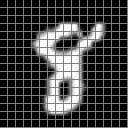
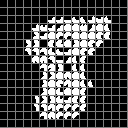
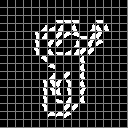
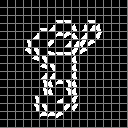
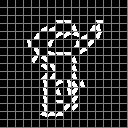
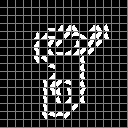
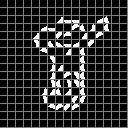
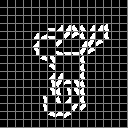
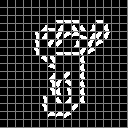
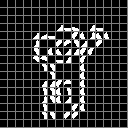
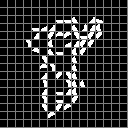
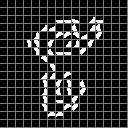
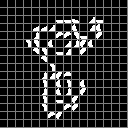
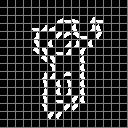
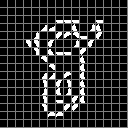
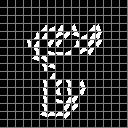
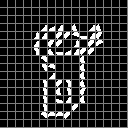
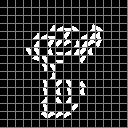
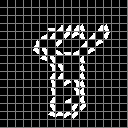
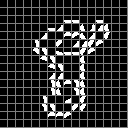
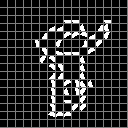
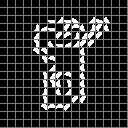
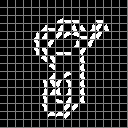
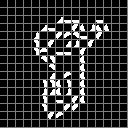
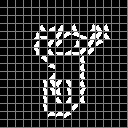
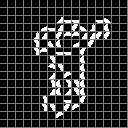
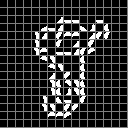
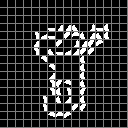
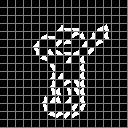
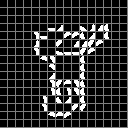
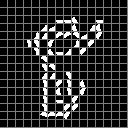
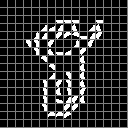
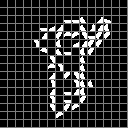
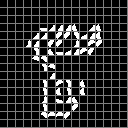
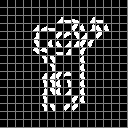
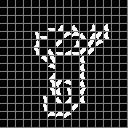
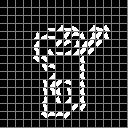
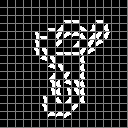
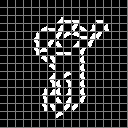
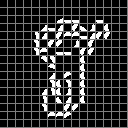
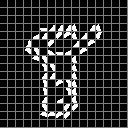
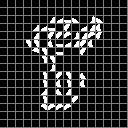
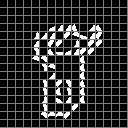

In [148]:
%%time
empty_image = Image.new('L', size=(1,1), color=255)
images = []
captions = []
col_count = 8

df_images = pd.read_sql_query('SELECT * FROM images', con=train_db_con, index_col='image_id')
#image_id = 9987
image_id = RNG.choice(df_images.index.unique())
image_data = df_images.loc[image_id]['png']
image = Image.open(io.BytesIO(image_data))
images.append(image)
captions.append(f'{image_id}, val={df_images.loc[image_id]['value']}')
images.extend([empty_image] * (col_count - 1))
captions.extend([''] * (col_count - 1))

column_id = -1
df_encodings = pd.read_sql_query('SELECT encoding, offset_x, offset_y, hdv FROM image_encodings WHERE image_id=:image_id AND column_id=:column_id AND retina_type=:retina_type', 
                                 params={'image_id': int(image_id), 'column_id': column_id, 'retina_type': config.retina_type}, 
                                 con=train_db_con)
sz = config.sample_size
encodings = []
bundle_layers = []

for _, enc_row in df_encodings.iterrows():
    encoding = np.frombuffer(enc_row['encoding'], dtype='b')
    encodings.append(encoding)
    encoding_dims = encoding.shape[0]
    encoding = encoding.reshape(SENSOR_GROUPS_COUNT, -1)
    layers = []

    for sensor_group_index, sensor_group in enumerate(encoding):
        assert sensor_group.shape == (SENSOR_GROUP_SQUARE, )
        speficic_samples_reactions_for_sensor_group = SPECIFIC_SAMPLES_REACTIONS[sensor_group_index]
        
        if np.any(sensor_group > 0):
            # Find most similar reaction among specific samples of reactions for given sensor group
            a = np.zeros(encoding_dims)
            assert a.shape[0] == speficic_samples_reactions_for_sensor_group.shape[1]
            a[sensor_group_index * SENSOR_GROUP_SQUARE:sensor_group_index * SENSOR_GROUP_SQUARE + SENSOR_GROUP_SQUARE] = sensor_group
            a = a / np.linalg.norm(a)
            b = speficic_samples_reactions_for_sensor_group
            b = (b.T / np.linalg.norm(b, axis=1)).T
            cos_sim = (a @ b.T)
            best_i = np.argmax(cos_sim)
            best_is.add((sensor_group_index, best_i))
            most_similar_specific_sample = np.array(SPECIFIC_SAMPLES_IMG[sensor_group_index][best_i])
            assert most_similar_specific_sample.shape == (sz, sz)
            layers.append(most_similar_specific_sample)
            bundle_layers.append(most_similar_specific_sample)

    sensor_map_image = np.zeros((sz, sz))
    
    for layer in layers:
        sensor_map_image += layer

    sensor_map_image[sensor_map_image != 0] = 255
    images.append(Image.frombytes('L', (sz, sz), data=sensor_map_image.ravel().astype('b')))
    captions.append(f'offset={enc_row['offset_x']}, {enc_row['offset_y']}')

bundle_sensor_map_image = np.zeros((sz, sz))
    
for layer in bundle_layers:
    bundle_sensor_map_image += layer

bundle_sensor_map_image[bundle_sensor_map_image != 0] = 255
images[1] = matrix_to_image(bundle_sensor_map_image)
captions[1] = 'bundle'

lay_grid_local = lambda i: lay_grid(i, 8)
display_images_grid(list(map(lay_grid_local, images)), captions=captions, col_count=col_count)

In [149]:
encodings = []
encoding_dims = 0
hdvs = []

for _, enc_row in df_encodings.iterrows():
    encoding = np.frombuffer(enc_row['encoding'], dtype='b')
    encodings.append(encoding)

    if encoding_dims:
        assert encoding_dims == encoding.shape[0]
    else:
        encoding_dims = encoding.shape[0]
        
    hdv = np.frombuffer(enc_row['hdv'], dtype='b')
    hdvs.append(hdv)

hdvs_bundle1 = hdc.bundle(hdvs) # 1) bundle horizontally (all strides within each encoding) 2) bundle vertically (all enconding bundles)

assert encoding_dims > 0
stride_encoding_hdvs_bundles = []

for stride_index in range(0, encoding_dims, SENSOR_GROUP_SQUARE):
    stride_encoding_hdvs = []
    
    for encoding in encodings:
        stride = encoding[stride_index:stride_index + SENSOR_GROUP_SQUARE]
        stride_code = ''.join(map(str, stride.tolist()))

        if not stride_code.replace('0', ''): # for relatively short strides this is ~x2 faster than np.all(stride == 0) or np.max(stride) == 0
            continue

        assert stride_code in STRIDE_HDVS
        stride_hdv = STRIDE_HDVS[stride_code]
        stride_hdv = hdc.shift(stride_hdv, stride_index)
        stride_encoding_hdvs.append(stride_hdv)

    if stride_encoding_hdvs:
        stride_encoding_hdvs_bundle = hdc.bundle(stride_encoding_hdvs)
        stride_encoding_hdvs_bundles.append(stride_encoding_hdvs_bundle)

hdvs_bundle2 = hdc.bundle(stride_encoding_hdvs_bundles) # 1) bundle vertically (all strides with the same indices) 2) bundle horizontally (all stride bundles)
hdc.sim(hdvs_bundle1, hdvs_bundle2)

np.float64(0.6014752369362932)